# Determine NN of all samples used in pairs list of the Balance Faces in the Wild (BFW) dataset.

Uses the data in `data/bfw-datatable.pkl` to determine the NN. Saves the summary to `results/bfw-stats.csv`.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.colors as colors

from facebias.iotools import load_bfw_datatable, save_bfw_datatable, load_features_from_image_list

import pathlib

# Load out custom tool for loading and processing the data
# from facebias.iotools import load_bfw_feature_lut
from facebias.preprocessing import encode_attribute_labels, encode_ethnicity_labels, encode_gender_labels
from facebias.visualization import set_defaults

In [6]:
set_defaults()

## Load the data

Get all feature paths and store as dictionary with keys set as the relative file paths.

In [9]:
# f_features = pathlib.Path('/Users/jrobby/bfw-data/features/resnet50/allfeatures.pkl')
dir_features = '../../data/bfw/features/senet50/'
files_features = glob.glob(f'{str(dir_features)}/*males/n*/*.npy')
files_features.sort()
data = pd.DataFrame(files_features, columns=['path'])


In [10]:
features = {f.replace(dir_features, ''): np.load(f) for f in files_features}
data.path = data.path.str.replace(dir_features, '')
print(f"{len(features)} features loaded")

20000 features loaded


In [11]:
data = pd.DataFrame(list(features.keys()), columns=['path'])
data.head()

data['att'] = data.path.apply(lambda x: x.split('/')[0]).astype('category')

data['id'] = data.path.apply(lambda x: "/".join(x.split('/')[:-1])).astype('category')

data['e'] = data.att.apply(lambda x: x.split('_')[0][0].upper())

data['g'] = data.att.apply(lambda x: x.split('_')[1][0].upper())

data['a'] = (data['e'] + data['g']).astype('category')

data['e'] = data['e'].astype('category')
data['g'] = data['g'].astype('category')

print(f"No. of Identities: {data.id.unique().shape[0]}\n"
      f"No. of Subgroups: {data.a.unique().shape[0]}\n"
      f"No. of Genders: {data.g.unique().shape[0]}\n"
      f"o. of Ethnics: {data.e.unique().shape[0]}\n")

data.head()

No. of Identities: 800
No. of Subgroups: 8
No. of Genders: 2
o. of Ethnics: 4



,path,att,id,e,g,a
0,asian_females/n000009/0010_01.npy,asian_females,asian_females/n000009,A,F,AF
1,asian_females/n000009/0011_01.npy,asian_females,asian_females/n000009,A,F,AF
2,asian_females/n000009/0012_01.npy,asian_females,asian_females/n000009,A,F,AF
3,asian_females/n000009/0013_01.npy,asian_females,asian_females/n000009,A,F,AF
4,asian_females/n000009/0017_01.npy,asian_females,asian_females/n000009,A,F,AF


## Calculate similarity matrix.

Pass N features to cosine_similarity; returns an NxN matrix of scores between ith row and jth column.

In [12]:
tup_features = tuple(features.items())
print(tup_features[0])

('asian_females/n000009/0010_01.npy', array([[7.9472065 , 0.01692374, 1.3884583 , ..., 0.04910585, 1.5160486 ,
        0.03306211]], dtype=float32))


In [13]:
score_matrix = cosine_similarity([feature for sublist in 
                                  data.path.apply(lambda x: features[x]).to_list() 
                                  for feature in sublist])

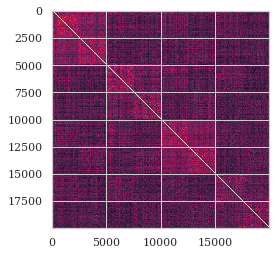

In [14]:
# score_matrix = cosine_similarity([f[1][0] for f in tup_features])

plt.imshow(score_matrix)

In [15]:
score_matrix[np.eye(len(score_matrix))==1]=0

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['id'].unique())
data['tag'] = le.transform(data['id'])
data['nn_ids'] = np.argmax(score_matrix, axis=1)
data.head()

,path,att,id,e,g,a,tag,nn_ids
0,asian_females/n000009/0010_01.npy,asian_females,asian_females/n000009,A,F,AF,0,1432
1,asian_females/n000009/0011_01.npy,asian_females,asian_females/n000009,A,F,AF,0,0
2,asian_females/n000009/0012_01.npy,asian_females,asian_females/n000009,A,F,AF,0,24
3,asian_females/n000009/0013_01.npy,asian_females,asian_females/n000009,A,F,AF,0,1
4,asian_females/n000009/0017_01.npy,asian_females,asian_females/n000009,A,F,AF,0,12


In [17]:
data['nn']=data.loc[data.nn_ids]['tag'].to_list()
data['nn_type']=data.loc[data.nn_ids]['a'].to_list()
data['tp'] = (data['tag'] == data['nn']).astype(int)
data['fn'] = (data['tag'] != data['nn']).astype(int)
data.head()

,path,att,id,e,g,a,tag,nn_ids,nn,nn_type,tp,fn
0,asian_females/n000009/0010_01.npy,asian_females,asian_females/n000009,A,F,AF,0,1432,57,AF,0,1
1,asian_females/n000009/0011_01.npy,asian_females,asian_females/n000009,A,F,AF,0,0,0,AF,1,0
2,asian_females/n000009/0012_01.npy,asian_females,asian_females/n000009,A,F,AF,0,24,0,AF,1,0
3,asian_females/n000009/0013_01.npy,asian_females,asian_females/n000009,A,F,AF,0,1,0,AF,1,0
4,asian_females/n000009/0017_01.npy,asian_females,asian_females/n000009,A,F,AF,0,12,0,AF,1,0


In [18]:
conf = data.groupby(by=['a','nn_type']).sum()['fn']
# /data.groupby(by=['a','nn_type']).count()['tp']
conf.head()
# data.groupby(by=['a','nn']).count().head()

a   nn_type
AF  AF         290.0
    AM          21.0
    BF           2.0
    BM           NaN
    IF           2.0
Name: fn, dtype: float64

In [19]:
# conf.head(20)
confusion_npy = conf.values.reshape(1,-1)
confusion_npy[np.isnan(confusion_npy)] = 0
confusion_npy=confusion_npy.reshape((8, -1))

print(confusion_npy)

[[290.  21.   2.   0.   2.   0.   0.   0.]
 [ 23. 168.   0.   0.   0.   3.   1.   2.]
 [  2.   0. 106.   8.   8.   0.   5.   0.]
 [  0.   0.  13. 100.   0.   3.   1.   3.]
 [  3.   0.   0.   0. 130.   4.   2.   0.]
 [  0.   6.   0.   1.   7. 110.   0.   3.]
 [  1.   1.   4.   0.   2.   0.  72.   4.]
 [  0.   2.   1.   1.   0.   6.   0.  19.]]


In [20]:
df_conf = pd.DataFrame(confusion_npy, index=data.a.unique(),
                       columns=data.a.unique())
print(f"\t\t\tNumber of FN\n{df_conf}")

			Number of FN
       AF     AM     BF     BM     IF     IM    WF    WM
AF  290.0   21.0    2.0    0.0    2.0    0.0   0.0   0.0
AM   23.0  168.0    0.0    0.0    0.0    3.0   1.0   2.0
BF    2.0    0.0  106.0    8.0    8.0    0.0   5.0   0.0
BM    0.0    0.0   13.0  100.0    0.0    3.0   1.0   3.0
IF    3.0    0.0    0.0    0.0  130.0    4.0   2.0   0.0
IM    0.0    6.0    0.0    1.0    7.0  110.0   0.0   3.0
WF    1.0    1.0    4.0    0.0    2.0    0.0  72.0   4.0
WM    0.0    2.0    1.0    1.0    0.0    6.0   0.0  19.0


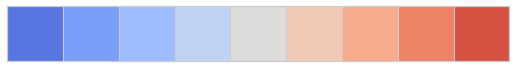

In [21]:
n_samples_per_subgroup=data.a.count()/data.a.nunique()
df_conf_percent_error = (df_conf/n_samples_per_subgroup)*100
colormap = sns.palplot(sns.color_palette("coolwarm",9))
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [22]:
import matplotlib.style as style
style.available
style.use('seaborn-paper') #sets the size of the charts
# style.use('ggplot')
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

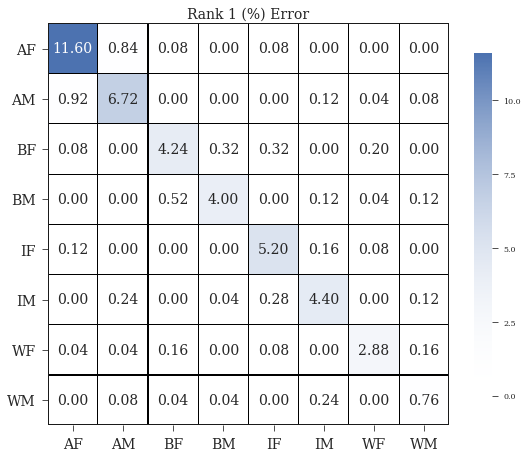

In [23]:
cmap = colors.LinearSegmentedColormap.from_list('nameofcolormap',['w','b'],gamma=2.0)
fig, ax = plt.subplots(figsize=(9,9))


ax=sns.heatmap(df_conf_percent_error, annot=True, linewidths=.1, square=True, cmap=cmap,
            cbar_kws={'shrink': .7, 'ticks': [0.0, 2.5, 5.0, 7.5, 10.0, 12.5]},
            linecolor='black', ax=ax, fmt='.2f', annot_kws={'size': 14},cbar=True)


# add the column names as labels
ax.set_yticklabels(df_conf_percent_error.columns, rotation=0, fontsize=14)
ax.set_xticklabels(df_conf_percent_error.columns, fontsize=14)
ax.set_xlabel(ax.get_xlabel(), size=14)
ax.axhline(y=0, color='k', linewidth=2)
ax.axhline(y=df_conf_percent_error.shape[1], color='k', linewidth=2)
ax.axvline(x=0, color='k', linewidth=2)
ax.axvline(x=df_conf_percent_error.shape[0], color='k', linewidth=2)
ax.set_title('Rank 1 (%) Error', fontsize=14)
plt.savefig('confusion.pdf', transparent=True)
